In this note, we look at constructing a finite element approximation to
$$
- \nabla\cdot \kappa(x,y) \nabla u = f(x,y)\quad\textrm{on $\Omega$}
$$
with
$u = g(x,y)$ on the boundary.  We define $\kappa$, $f$, and $g$ in a bit.

First, let's read in a mesh.  Here we use a list of vertices (in $x$- and $y$-coordinates) and triangular elements (ie, a list of three vertices).  An example on $[-1, 1]$ is given here: https://gist.github.com/lukeolson/3705bf0b770476b66d61

In [2]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
V = np.loadtxt('mesh.v')
E = np.loadtxt('mesh.e', dtype=int)
#import refine_mesh
#V, E = refine_mesh.refine2dtri(V, E)
nv = V.shape[0]
ne = E.shape[0]
print(V.shape)
print(E.shape)
print(E.max())
X, Y = V[:, 0], V[:, 1]

(373, 2)
(688, 3)
372


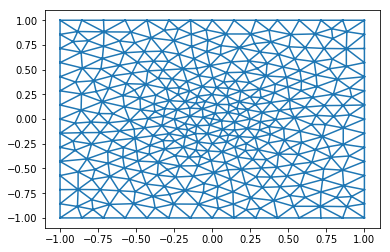

In [4]:
plt.triplot(X, Y, E)
plt.show()

Now do some things to the mesh
- `G` is the adjacency matrix (V to E connections)
- `E2E` identifies element-to-element connections
- `V2V` identifies vertex-to-vertex connections

V shape:  (373, 2)
E shape:  (688, 3)
G shape:  (373, 688)
V2V shape:  (373, 373)
E2E shape:  (688, 688)


/usr/local/lib/python3.6/site-packages/scipy/sparse/coo.py:359: SparseEfficiencyWarning: Constructing a DIA matrix with 563 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


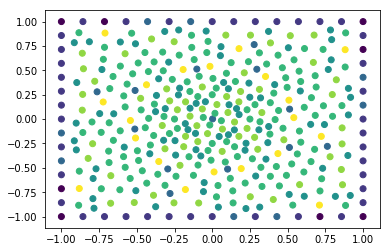

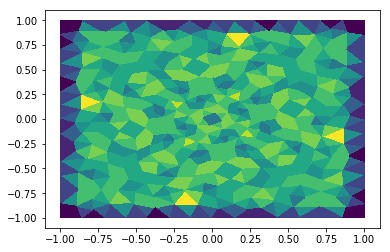

In [7]:
print('V shape: ', V.shape)
print('E shape: ', E.shape)
ID = np.kron(np.arange(0, ne), np.ones((3,)))
G = sparse.coo_matrix((np.ones((ne*3,)), (E.ravel(), ID,)))
print('G shape: ', G.shape)
E2E = G.T * G
V2V = G * G.T
V2V = V2V.todia()
print('V2V shape: ', V2V.shape)
print('E2E shape: ', E2E.shape)
plt.scatter(X, Y, c=V2V.diagonal(), clip_on=False)
plt.show()
E2E.data = 0.0 * E2E.data + 1.0
nbrs = np.array(E2E.sum(axis=0)).ravel()
plt.tripcolor(X, Y, triangles=E, facecolors=nbrs)
plt.show()

At this point we have `nv` vertices and `ne` elements.  We seek a solution of the form
$$
u^h = \sum_{j=i}^{nv}u_i \phi_i(x,y)
$$
where $\phi_i(x,y)$ are linear basis functions and $\{\phi_i\}_{i=1}^{nv}$ spans $V^h$, the space of piecewise linear, continous functions on the mesh.

To do this, we consider the weak form of this problem: find $u^h\in V^h$ such that
$$
\int_{\Omega} \kappa(x,y)\nabla u^h \cdot \nabla \phi_j \,dx = \int_{\Omega} f \phi_j\,dx,
$$
for all $\phi_j$.  Or,
$$
\sum_{i=1}^{nv}u_i \int_{\Omega} \kappa(x,y)\nabla \phi_i \cdot \nabla \phi_j \,dx = \int_{\Omega} f \phi_j\,dx,
$$

To simplify the evaluation of these integrals, we consider them over each mesh element $\tau$.  To do this, we write a Lagrange basis function $\phi(x,y)$ on mesh element $\tau$ in terms of the linear nodal basis function on a *reference* element, $\hat{\tau}$, call this $\lambda(\alpha, \beta)$.  Let $(0,0)$, $(1,0)$, and $(0,1)$ represented the $\hat{\tau}$ be the reference element with basis functions
$$
\lambda_1(\alpha, \beta) = 1 - \alpha - \beta,\quad
\lambda_2(\alpha, \beta) = \alpha,\quad
\lambda_3(\alpha, \beta) = \beta.
$$

Notice that the gradient of these basis functions are
$$
\nabla \lambda_1 = \begin{bmatrix}1\\1\end{bmatrix},\quad
\nabla \lambda_2 = \begin{bmatrix}1\\0\end{bmatrix},\quad
\nabla \lambda_3 = \begin{bmatrix}0\\1\end{bmatrix}
$$

The key is that if $T(\alpha, \beta) = C \begin{bmatrix}\alpha\\\beta\end{bmatrix} + c$ is a transformation from $\hat{\tau}$ to $\tau$, then we can define the linear nodal basis functions on $\tau$ by
$$
\phi_r(x,y) = \lambda_r(T^{-1}(x,y))
$$
where $r=1,2,3$.

This transformation is straightforward to define: the reference coordinate system maps to the coordinate system at $v_1$ with axis $v_2 - v_1$ and $v_3 - v_1$ by
$$
T(\alpha, \beta) = (v_2 - v_1) \alpha + (v_3 - v_1) \beta + v_1
$$
where $v_r = \begin{bmatrix}x_r\\ y_r\end{bmatrix}$ for each vertex $r=1,2,3$.

Let's take a look.  Let's map the reference triangle to $(1,1)$, $(3, 1)$, $(2,2)$.

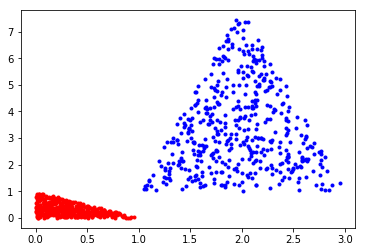

In [8]:
XX = np.random.rand(1000)
YY = np.random.rand(1000)
I = np.where((XX + YY)<1.0)[0]
alph = XX[I]
beta = YY[I]
v1 = np.array([1.0, 1.0])
v2 = np.array([3.0, 1.0])
v3 = np.array([2.0, 8.0])
Tx = (v2[0] - v1[0]) * alph + (v3[0] - v1[0]) * beta + v1[0]
Ty = (v2[1] - v1[1]) * alph + (v3[1] - v1[1]) * beta + v1[1]
plt.plot(alph, beta,'r.')
plt.plot(Tx,Ty, 'b.')
plt.show()

Let's define $\kappa(x,y)$, $f(x,y)$, and $g(x,y)$.

$$
\kappa = 
\begin{cases}
25 & if \sqrt{x^2 + y^2} \leq 0.25\\
0.1 & else
\end{cases}
$$

$$
f = 
\begin{cases}
25 & if \sqrt{x^2 + y^2} \leq 0.25\\
0 & else
\end{cases}
$$

$$
g = 10 (1-x^2)
$$

In [9]:
def kappa(x, y):
    if (x**2 + y**2)**0.5 <= 0.25:
        return 1.0
    else:
        return 1.0


def f(x, y):
    if (x**2 + y**2)**0.5 <= 0.25:
        return 50.0
    else:
        return 0.0

    
def g(x):
    return 10 * (1 - x**2)    

The Jacobian $J$ of transformation $T$ is important since
$$
\int_{\hat{\tau}} f(x) \, dx = \int_{\tau} f(T(x)) |J|, dx.
$$
In our case,
$$
J = 
\begin{bmatrix}
v_3 - v_1 & v_2 - v_1
\end{bmatrix}
=
\begin{bmatrix}
x_3 - x_1 & x_2 - x_1\\
y_3 - y_1 & y_2 - y_1
\end{bmatrix}
$$

Moreover, since the Jacobian of the inverse is the inverse of the Jacobian, we have
$$
\nabla \phi_r = \nabla \lambda_r(T^{-1}(x, y)) = J^{-T} \nabla \lambda_r
$$
Since $\lambda_r$ is constant and since $J$ is constant per triangle, these are taken outside of the integral.

If we visit each element to compute the contributions of
$$
\sum_{i=1}^{nv}u_i \int_{\Omega} \kappa(x,y)\nabla \phi_i \cdot \nabla \phi_j \,dx = \int_{\Omega} f \phi_j\,dx,
$$
then there are three basis functions $\phi_i$ interacting with three basis functions $\phi_j$.  Thus nine entries per element.  Let's allocate that space:

In [10]:
AA = np.zeros((ne, 9))
IA = np.zeros((ne, 9))
JA = np.zeros((ne, 9))
bb = np.zeros((ne, 3))
ib = np.zeros((ne, 3))
jb = np.zeros((ne, 3))

Here we have created space for the data, row, and column indices of the matrix (`AA`, `IA`, `JA`) and of the right-hand side (`bb`, `ib`).

The loop over elements follows several steps:

For each element $\tau$ do the following

1. Get the coordinates of the element

2. Compute the Jacobian $J$, the inverse transpose $J^{-T}$, and the determinant $|J|$).  Call theese `J`, `invJ`, and `detJ`.

3. Define the gradient of the reference basis functions $\nabla \phi_r$ (this is actually constant for each element...see above).  Call these `dlambda`.

4. Compute the gradient of the real basis functions $\nabla \phi_r = J^{-T} \lambda_r$.  Call these `dphi`.

5. Now calculate the bilinear form on the element:
$$
\int_{\tau} \kappa(x) \nabla \phi_r \cdot \nabla \phi_s\,dx\\
=\int_{\tau} \kappa(x) (J^{-T}\nabla\lambda_r)^T (J^{-T}\nabla\lambda_s)\,dx\\
=(J^{-T}\nabla\lambda_r)^T (J^{-T}\nabla\lambda_s)|J|\int_{\tau} \kappa(T(\alpha, \beta))\,d\alpha\,d\beta
$$
Compute $\int_{\tau} \kappa$ using a 1-point Gauss Quadrature rule 
$$
\approx (1/2) \kappa(\bar{x}, \bar{y})
$$

7. Compute the right-hand side:
$$
\int_{E} f(x) \phi_r\,dx\\
= |J| \int_{\tau} f(T(\alpha)) \lambda_r(\alpha)\,d\alpha
$$
Now using a 1-point Gauss Quadrature rule gives
$$
\approx (1/2) f(\bar{x}, \bar{y}) \lambda_r(\bar{\alpha}, \bar{\beta})\\
= (1/6) f(\bar{x}, \bar{y})
$$

7. Add these to the matrix depending $i$ and $j$

In [11]:
for ei in range(0, ne):
    # Step 1
    K = E[ei, :]
    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]

    # Step 2
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = la.inv(J.T)
    detJ = la.det(J)

    # Step 3
    dbasis = np.array([[-1, 1, 0],
                       [-1, 0, 1]])

    # Step 4
    dphi = invJ.dot(dbasis)

    # Step 5
    Aelem = kappa(X[K].mean(), Y[K].mean()) *\
        (detJ / 2.0) * (dphi.T).dot(dphi)

    # Step 6
    belem = f(X[K].mean(), Y[K].mean()) *\
        (detJ / 6.0) * np.ones((3,))

    # Step 7
    AA[ei, :] = Aelem.ravel()
    IA[ei, :] = [K[0], K[0], K[0], K[1], K[1], K[1], K[2], K[2], K[2]]
    JA[ei, :] = [K[0], K[1], K[2], K[0], K[1], K[2], K[0], K[1], K[2]]
    bb[ei, :] = belem.ravel()
    ib[ei, :] = [K[0], K[1], K[2]]
    jb[ei, :] = 0


The matrices were constructed in COO format, meaning that
duplicates were formed.  Convert to CSR to contract the duplicate
entries.  Then convert back to COO for easier manipulation.

In [12]:
A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A = A.tocsr()
A = A.tocoo()
b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel())))
b = b.tocsr()
b = np.array(b.todense()).ravel()

Next, boundary conditions are applied in this step.  First, define a function $u_0$ that is equal to $g$ on the $x=0$ boundary and
zero elsewhere.  To do this, first create two boolean vectors: one
that is true for each vertex on the $y=1$ boundary (`gflag`) and the other that
is true for each vertex on the whole boundary (`Dflag`).  Then
set $u_0$ appropriately.

Next, we need to set
$$
b \leftarrow b - A u_0,
$$
which is just a matrix-vector product.  Finally, we need to set:
$$
A_{ij} = 0\\
A_{ii} = 1\\
b_{i} = 0,
$$
for each boundary node $i$.  The best strategy is to loop over all of
the non-zero entries in $A$ by looking at `A.row`,
`A.col`, and `A.data` in COO format.  Check each
row/column index for presence on the boundary and set the values
accordingly.

First flag the locations of the boundary 

In [13]:
tol = 1e-12
Dflag = np.logical_or.reduce((abs(X+1) < tol,
                              abs(X-1) < tol,
                              abs(Y+1) < tol,
                              abs(Y-1) < tol))
gflag = abs(Y+1) < tol
ID = np.where(Dflag)[0]
Ig = np.where(gflag)[0]

Then construct $u_0(x,y) = g(x)$ for $y=1$ and zero elsewhere

In [14]:
u0 = np.zeros((nv,))
u0[Ig] = g(X[Ig])

b = b - A * u0

Then mark the diagonal as 1.0 and the off diagonals as 0.0 for each boundary vertex

In [15]:
for k in range(0, len(A.data)):
    i = A.row[k]
    j = A.col[k]
    if Dflag[i] or Dflag[j]:
        if i == j:
            A.data[k] = 1.0
        else:
            A.data[k] = 0.0

b[ID] = 0.0

Now solve (and correct from above)

In [16]:
A = A.tocsr()
u = sla.spsolve(A, b)

u = u + u0

And plot

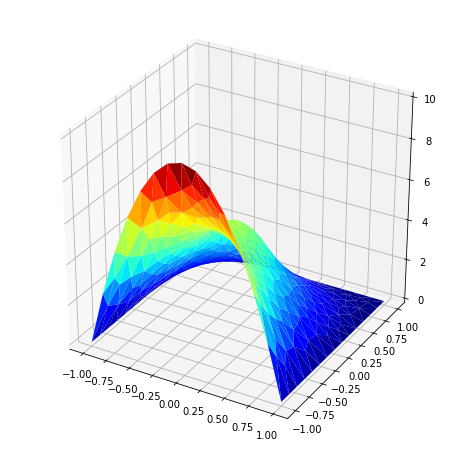

In [17]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection='3d')
ax.plot_trisurf(X, Y, u, triangles=E, cmap=plt.cm.jet, linewidth=0.2)
plt.show()